# Quantile Regression based on FCI

In [42]:
import pandas as pd
import numpy as np

#Loading data

# fci_quart_data = pd.read_pickle('fci_processed/double_pca_quart_fci.pkl')
# #changing to percentage points
# fci_quart_data = fci_quart_data.dropna(axis=0, how='any')
# fci_quart_data['quarterly_ggdp_ppp_growth_annualized'] = fci_quart_data['quarterly_ggdp_ppp_growth_annualized'] * 100

# trying fci_2
fci_quart_data = pd.read_pickle('fci_processed/double_pca_quart_fci_2.pkl')
#changing to percentage points
fci_quart_data = fci_quart_data.dropna(axis=0, how='any')
fci_quart_data['quarterly_ggdp_ppp_growth_annualized'] = fci_quart_data['quarterly_ggdp_ppp_growth_annualized'] * 100

## Does FCI Granger cause GGDP growth?
We will estimate the $ADL(h,h)$ model: $ GGDP_{t+h} = \alpha + \beta \cdot GGDP_{t} + \delta \cdot FCI_{t} $

In [43]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

lag = 3
# 
# sel_res = ardl_select_order(
#     fci_quart_data['quarterly_ggdp_ppp_growth_annualized'], [1, 2, 3, 4],
#     fci_quart_data[['quarterly_ggdp_ppp_growth_annualized', 'double_pca_fci']], 4, ic="bic", trend="c", glob=True)
# 
# print(sel_res.model.ardl_order)
# print(sel_res.model.fit().summary())

adl_model = ARDL(fci_quart_data['quarterly_ggdp_ppp_growth_annualized'],
                 [lag],
                 fci_quart_data[['quarterly_ggdp_ppp_growth_annualized', 'double_pca_fci']],
                 {"double_pca_fci": [lag]})

print(adl_model.fit().summary())


                                       ARDL Model Results                                       
Dep. Variable:     quarterly_ggdp_ppp_growth_annualized   No. Observations:                  134
Model:                                       ARDL(3, 3)   Log Likelihood                -380.209
Method:                                 Conditional MLE   S.D. of innovations              4.408
Date:                                  Tue, 30 Jul 2024   AIC                            768.418
Time:                                          16:53:35   BIC                            779.919
Sample:                                      01-01-1991   HQIC                           773.091
                                           - 07-01-2023                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const   

C:\Users\yarde\anaconda3\envs\ggdp-research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\yarde\anaconda3\envs\ggdp-research\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: quarterly_ggdp_ppp_growth_annualized.
  return _format_order(self.data.orig_exog, order, self._causal)


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

from quantile_regression_functions import Lag, fit_qr, estimate_quantiles, predict_quantiles

sns.set_style('white')

#creates a range from 0.05 to 0.95 with step of 0.05
quantiles = np.arange(0.05, 0.96, 0.05, dtype=float)
quantiles = np.round(quantiles, 2)
alpha = 0.05

#### one quarter ahead
lag = 1
formula = f'quarterly_ggdp_ppp_growth_annualized ~ Lag(double_pca_fci, {lag})'

#estimating quantiles
qr_res_list_1, ols_model_summary_1 = estimate_quantiles(quantiles, formula, fci_quart_data, alpha=alpha)
models_summary_df_1_quart = pd.DataFrame([res.to_list() for res in qr_res_list_1], columns=['q', 'a', 'b', 'lb', 'ub'])
#predicting quantiles
# quantiles_to_predict = [0.05, 0.25, 0.5, 0.75, 0.95]


quantiles_to_predict = quantiles
q_predict_1_quart = predict_quantiles(qr_res_list_1, lag, quantiles_to_predict, fci_quart_data, 'double_pca_fci',
                                      ols_model_summary=ols_model_summary_1)
q_predict_1_quart = q_predict_1_quart.join(fci_quart_data['quarterly_ggdp_ppp_growth_annualized'])
q_predict_1_quart = q_predict_1_quart.rename(columns={'quarterly_ggdp_ppp_growth_annualized': 'realized_ggdp_growth'})

#### one year (4 quarters) ahead
lag = 4
formula = f'quarterly_ggdp_ppp_growth_annualized ~ Lag(double_pca_fci, {lag})'

#estimating quantiles
qr_res_list_4, ols_model_summary_4 = estimate_quantiles(quantiles, formula, fci_quart_data, alpha=alpha)

models_summary_df_4_quart = pd.DataFrame([res.to_list() for res in qr_res_list_4], columns=['q', 'a', 'b', 'lb', 'ub'])
#predicting quantiles
quantiles_to_predict = [0.05, 0.25, 0.5, 0.75, 0.95]
q_predict_4_quart = predict_quantiles(qr_res_list_4, lag, quantiles_to_predict, fci_quart_data, 'double_pca_fci',
                                      ols_model_summary=ols_model_summary_4)
q_predict_4_quart = q_predict_4_quart.join(fci_quart_data['quarterly_ggdp_ppp_growth_annualized'])
q_predict_4_quart = q_predict_4_quart.rename(columns={'quarterly_ggdp_ppp_growth_annualized': 'realized_ggdp_growth'})

#saving results both to pickle and to csv to be able to use in r
q_predict_1_quart.to_pickle('gar_analysis/q_predict_1_quart.pkl')
q_predict_1_quart.to_csv('gar_analysis/q_predict_1_quart.csv')
q_predict_4_quart.to_pickle('gar_analysis/q_predict_4_quart.pkl')
q_predict_4_quart.to_csv('gar_analysis/q_predict_4_quart.csv')

#### Summary Table for p-vals at different quantiles
sig_level = 0.05

summary_1 = pd.DataFrame([(res.q, res.a_p_value, res.b_p_value) for res in qr_res_list_1],
                         columns=['q', 'a_pval', 'b_pval'])

summary_1['significant_a'] = summary_1['a_pval'] < sig_level
summary_1['significant_b'] = summary_1['b_pval'] < sig_level
print(summary_1)

summary_4 = pd.DataFrame([(res.q, res.a_p_value, res.b_p_value) for res in qr_res_list_4],
                         columns=['q', 'a_pval', 'b_pval'])

summary_4['significant_a'] = summary_4['a_pval'] < sig_level
summary_4['significant_b'] = summary_4['b_pval'] < sig_level
print(summary_4)

sns.set(style="whitegrid")

# Function to plot the table
# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)


# Function to style the table
def style_table(df, title):
    styled_df = df.style.set_caption(title).set_table_styles(
        [{'selector': 'caption', 'props': [('text-align', 'center'), ('font-size', '16px'), ('font-weight', 'bold')]}]
    ).set_properties(**{
        'background-color': 'white',
        'color': 'black',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px',
        'text-align': 'center',
    }).format(
        precision=4, subset=['a_pval', 'b_pval']
    ).highlight_between(
        subset=['a_pval', 'b_pval'], left=0, right=0.05, color='lightgreen', axis=1
    )

    return styled_df


# Style and display summary_1
styled_summary_1 = style_table(summary_1, 'Summary Table for One Quarter Ahead')
display(styled_summary_1)

# Style and display summary_4
styled_summary_4 = style_table(summary_4, 'Summary Table for One Year (4 Quarters) Ahead')
display(styled_summary_4)

## trying the ADL model - consists of both GGDP and FCI lagged by 3

# lag = 3
# formula = f'quarterly_ggdp_ppp_growth_annualized ~ Lag(double_pca_fci, {lag}) + Lag(quarterly_ggdp_ppp_growth_annualized, {lag})'
# 
# #estimating quantiles
# qr_res_list_3, ols_model_summary_3 = estimate_quantiles(quantiles, formula, fci_quart_data)
# 
# models_summary_df_3_quart = pd.DataFrame([res.to_list() for res in qr_res_list_3], columns=['q', 'a', 'b', 'lb', 'ub'])
# #predicting quantiles
# quantiles_to_predict = [0.05, 0.25, 0.5, 0.75, 0.95]
# q_predict_3_quart = predict_quantiles(qr_res_list_3, lag, quantiles_to_predict, fci_quart_data, 'double_pca_fci',
#                                       ols_model_summary=ols_model_summary_3)
# q_predict_3_quart = q_predict_3_quart.join(fci_quart_data['quarterly_ggdp_ppp_growth_annualized'])
# q_predict_3_quart = q_predict_3_quart.rename(columns={'quarterly_ggdp_ppp_growth_annualized': 'realized_ggdp_growth'})

#saving results both to pickle and to csv to be able to use in r
# q_predict_1_quart.to_pickle('gar_analysis/q_predict_1_quart.pkl')
# q_predict_1_quart.to_csv('gar_analysis/q_predict_1_quart.csv')
# q_predict_4_quart.to_pickle('gar_analysis/q_predict_4_quart.pkl')
# q_predict_4_quart.to_csv('gar_analysis/q_predict_4_quart.csv')


C:\Users\yarde\anaconda3\envs\ggdp-research\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\yarde\PycharmProjects\ggdp_research\quantile_regression_functions.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ols_model_summary = dict(a=ols_model.params[0], b=ols_model.params[1], lb=ols_ci[0], ub=ols_ci[1])
C:\Users\yarde\anaconda3\envs\ggdp-research\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\yarde\PycharmProjects\ggdp_research\quantile_regression_functions.py:60: FutureW

       q        a_pval    b_pval  significant_a  significant_b
0   0.05  2.733753e-04  0.003097           True           True
1   0.10  4.684072e-02  0.002931           True           True
2   0.15  3.725074e-01  0.000081          False           True
3   0.20  4.966356e-03  0.000195           True           True
4   0.25  1.876268e-05  0.000314           True           True
5   0.30  5.289284e-08  0.000052           True           True
6   0.35  1.332050e-10  0.000040           True           True
7   0.40  1.456671e-12  0.000046           True           True
8   0.45  2.694222e-14  0.000016           True           True
9   0.50  6.563310e-16  0.000035           True           True
10  0.55  3.370498e-17  0.000017           True           True
11  0.60  5.439534e-21  0.000081           True           True
12  0.65  1.104090e-23  0.003020           True           True
13  0.70  2.645518e-25  0.005191           True           True
14  0.75  7.129621e-26  0.002581           True        

,q,a_pval,b_pval,significant_a,significant_b
0,0.050000,0.0003,0.0031,True,True
1,0.100000,0.0468,0.0029,True,True
2,0.150000,0.3725,0.0001,False,True
3,0.200000,0.0050,0.0002,True,True
4,0.250000,0.0000,0.0003,True,True
5,0.300000,0.0000,0.0001,True,True
6,0.350000,0.0000,0.0000,True,True
7,0.400000,0.0000,0.0000,True,True
8,0.450000,0.0000,0.0000,True,True
9,0.500000,0.0000,0.0000,True,True


,q,a_pval,b_pval,significant_a,significant_b
0,0.050000,0.0048,0.0292,True,True
1,0.100000,0.2893,0.0757,False,False
2,0.150000,0.0953,0.0114,False,True
3,0.200000,0.0042,0.0141,True,True
4,0.250000,0.0000,0.0490,True,True
5,0.300000,0.0000,0.0137,True,True
6,0.350000,0.0000,0.0033,True,True
7,0.400000,0.0000,0.0005,True,True
8,0.450000,0.0000,0.0004,True,True
9,0.500000,0.0000,0.0039,True,True


## Testing Linear relationship hypothesis

For each quantile we will calculate using OLS the model at quantile $\tau$ : $GGDP\_Growth_{t+h}(\tau) = \alpha(\tau) + \beta(\tau) \cdot FCI_t$

By doing this we can estimate the confidence interval for the hypothesis $$H_0: \beta(\tau) = 0 \\ H_1: \beta(\tau) \neq 0$$
If $\hat{\beta(\tau)} \notin CI$ then we can reject the null of not having a linear relationship, meaning there is a non-linear relationship

In [45]:


# models_summary_df_1_quart.index = models_summary_df_1_quart['q']
# models_summary_df_4_quart.index = models_summary_df_4_quart['q']

#testing with specific lag
# 

# results = []
# quantile_names = {q: f'Q_{int(100 * q)}' for q in quantiles}
# q_predict_1_quart = q_predict_1_quart.rename(columns=quantile_names)
# models_summary_df_1_quart = models_summary_df_1_quart.rename(columns=quantile_names)
# 
# for _, q in quantile_names.items():
#     lag = 1
#     #
#     formula = f'{q} ~ Lag(double_pca_fci, {lag})'
#     ols_lag_1_model = sm.OLS.from_formula(formula, data=q_predict_1_quart).fit()
#     ols_param_names = ols_lag_1_model.params.index.to_list()
#     curr_ci = ols_lag_1_model.conf_int().loc[ols_param_names[1]].to_list()
#     results.append((curr_ci[0], curr_ci[1]))
# 
# ols_ci_df = pd.DataFrame(results, columns=['ols_lb', 'ols_ub'], index=quantiles)
# models_summary_df_1_quart = models_summary_df_1_quart.join(ols_ci_df)



## Plotting Quantile Regression Estimated Coefficients

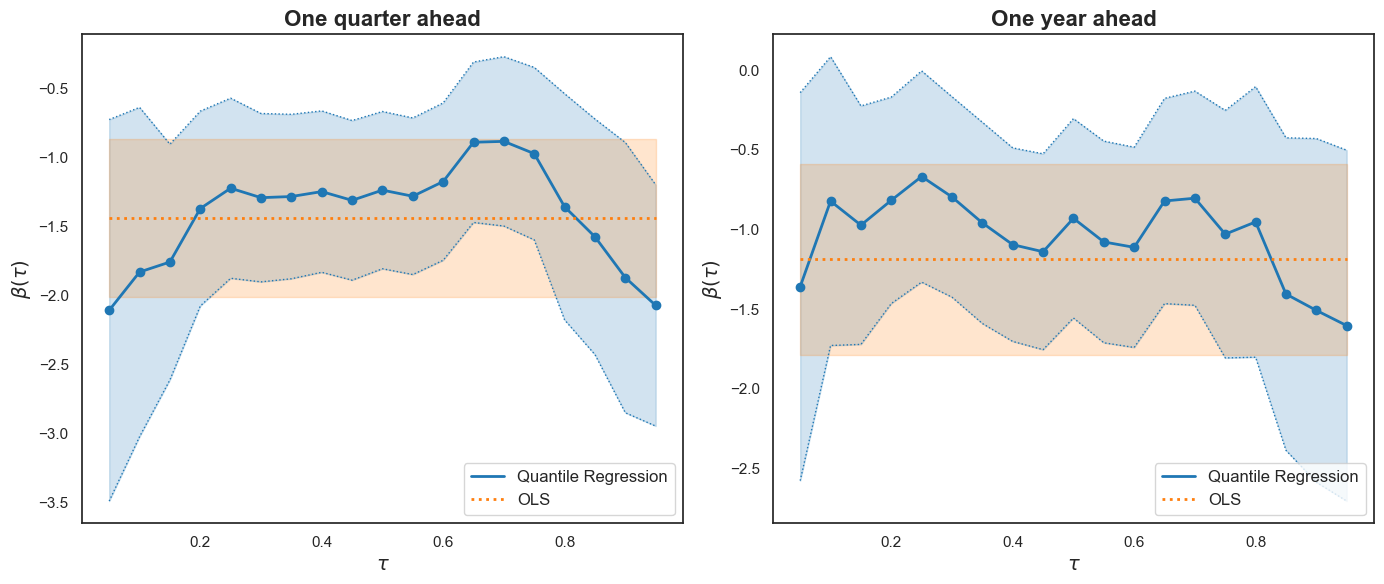

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style('white')

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot for one quarter ahead
ax1.plot(models_summary_df_1_quart.q, models_summary_df_1_quart.b, color="#1f77b4", label="Quantile Regression",
         linewidth=2)
ax1.plot(models_summary_df_1_quart.q, models_summary_df_1_quart.ub, linestyle="dotted", color="#1f77b4", linewidth=1)
ax1.plot(models_summary_df_1_quart.q, models_summary_df_1_quart.lb, linestyle="dotted", color="#1f77b4", linewidth=1)

# Fill the area between the upper and lower bounds of the quantile regression
ax1.fill_between(models_summary_df_1_quart.q, models_summary_df_1_quart.lb, models_summary_df_1_quart.ub,
                 color='#1f77b4', alpha=0.2)

ax1.scatter(models_summary_df_1_quart.q, models_summary_df_1_quart.b, color="#1f77b4", edgecolor='face', zorder=5)

# Plot OLS line and fill the confidence interval
ax1.plot(models_summary_df_1_quart.q, [ols_model_summary_1["b"]] * len(models_summary_df_1_quart.q), color="#ff7f0e",
         linestyle="dotted", label="OLS", linewidth=2)
ax1.fill_between(models_summary_df_1_quart.q, ols_model_summary_1["lb"], ols_model_summary_1["ub"], color='#ff7f0e',
                 alpha=0.2)

ax1.set_xlabel(r"$\tau$", fontsize=14)
ax1.set_ylabel(r"$\beta(\tau)$", fontsize=14)
ax1.set_title("One quarter ahead", fontsize=16, fontweight='bold')
ax1.legend(loc='lower right', fontsize=12)
ax1.grid(False)

# Plot for one year ahead
ax2.plot(models_summary_df_4_quart.q, models_summary_df_4_quart.b, color="#1f77b4", label="Quantile Regression",
         linewidth=2)
ax2.plot(models_summary_df_4_quart.q, models_summary_df_4_quart.ub, linestyle="dotted", color="#1f77b4", linewidth=1)
ax2.plot(models_summary_df_4_quart.q, models_summary_df_4_quart.lb, linestyle="dotted", color="#1f77b4", linewidth=1)

# Fill the area between the upper and lower bounds of the quantile regression
ax2.fill_between(models_summary_df_4_quart.q, models_summary_df_4_quart.lb, models_summary_df_4_quart.ub,
                 color='#1f77b4', alpha=0.2)

ax2.scatter(models_summary_df_4_quart.q, models_summary_df_4_quart.b, color="#1f77b4", edgecolor='face', zorder=5)

# Plot OLS line and fill the confidence interval
ax2.plot(models_summary_df_4_quart.q, [ols_model_summary_4["b"]] * len(models_summary_df_4_quart.q), color="#ff7f0e",
         linestyle="dotted", label="OLS", linewidth=2)
ax2.fill_between(models_summary_df_4_quart.q, ols_model_summary_4["lb"], ols_model_summary_4["ub"], color='#ff7f0e',
                 alpha=0.2)

ax2.set_xlabel(r"$\tau$", fontsize=14)
ax2.set_ylabel(r"$\beta(\tau)$", fontsize=14)
ax2.set_title("One year ahead", fontsize=16, fontweight='bold')
ax2.legend(loc='lower right', fontsize=12)
ax2.grid(False)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("plots/beta_hat_quantile_reg.png")
plt.show()


# Realization vs Predicted distributions

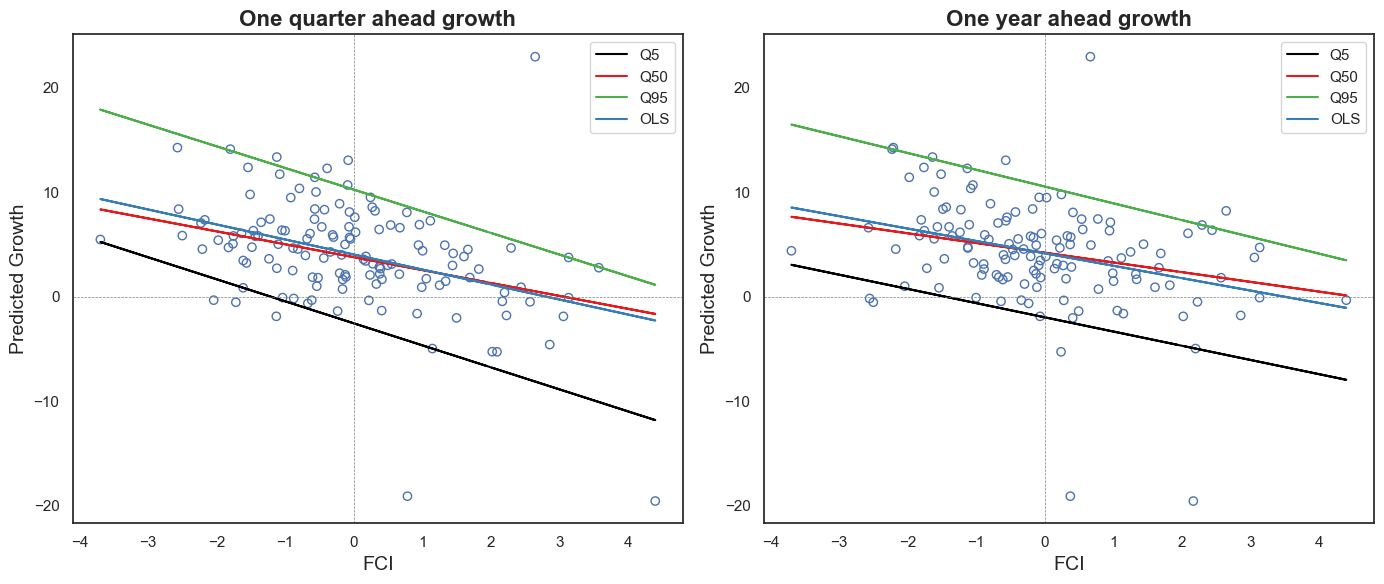

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style('white')

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot for one quarter ahead
ax1.scatter(q_predict_1_quart['double_pca_fci'], q_predict_1_quart['realized_ggdp_growth'], facecolors='none',
            edgecolors='b')
ax1.plot(q_predict_1_quart['double_pca_fci'], q_predict_1_quart[0.05], color="black", linestyle='solid', label="Q5",
         linewidth=1.5)
ax1.plot(q_predict_1_quart['double_pca_fci'], q_predict_1_quart[0.5], color="#e41a1c", linestyle='solid', label="Q50",
         linewidth=1.5)
ax1.plot(q_predict_1_quart['double_pca_fci'], q_predict_1_quart[0.95], color="#4daf4a", linestyle='solid', label="Q95",
         linewidth=1.5)
ax1.plot(q_predict_1_quart['double_pca_fci'], q_predict_1_quart['ols'], color="#377eb8", linestyle='solid', label="OLS",
         linewidth=1.5)

ax1.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

ax1.set_title('One quarter ahead growth', fontsize=16, fontweight='bold')
ax1.set_xlabel('FCI', fontsize=14)
ax1.set_ylabel('Predicted Growth', fontsize=14)
ax1.legend()
ax1.grid(False)

# Plot for one year ahead
ax2.scatter(q_predict_4_quart['double_pca_fci'], q_predict_4_quart['realized_ggdp_growth'], facecolors='none',
            edgecolors='b')
ax2.plot(q_predict_4_quart['double_pca_fci'], q_predict_4_quart[0.05], color="black", linestyle='solid', label="Q5",
         linewidth=1.5)
ax2.plot(q_predict_4_quart['double_pca_fci'], q_predict_4_quart[0.5], color="#e41a1c", linestyle='solid', label="Q50",
         linewidth=1.5)
ax2.plot(q_predict_4_quart['double_pca_fci'], q_predict_4_quart[0.95], color="#4daf4a", linestyle='solid', label="Q95",
         linewidth=1.5)
ax2.plot(q_predict_4_quart['double_pca_fci'], q_predict_4_quart['ols'], color="#377eb8", linestyle='solid', label="OLS",
         linewidth=1.5)

ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax2.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

ax2.set_title('One year ahead growth', fontsize=16, fontweight='bold')
ax2.set_xlabel('FCI', fontsize=14)
ax2.set_ylabel('Predicted Growth', fontsize=14)
ax2.legend()
ax2.grid(False)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("plots/predicted_select_quantiles_growth.png")
plt.show()


## Predicted Distributions

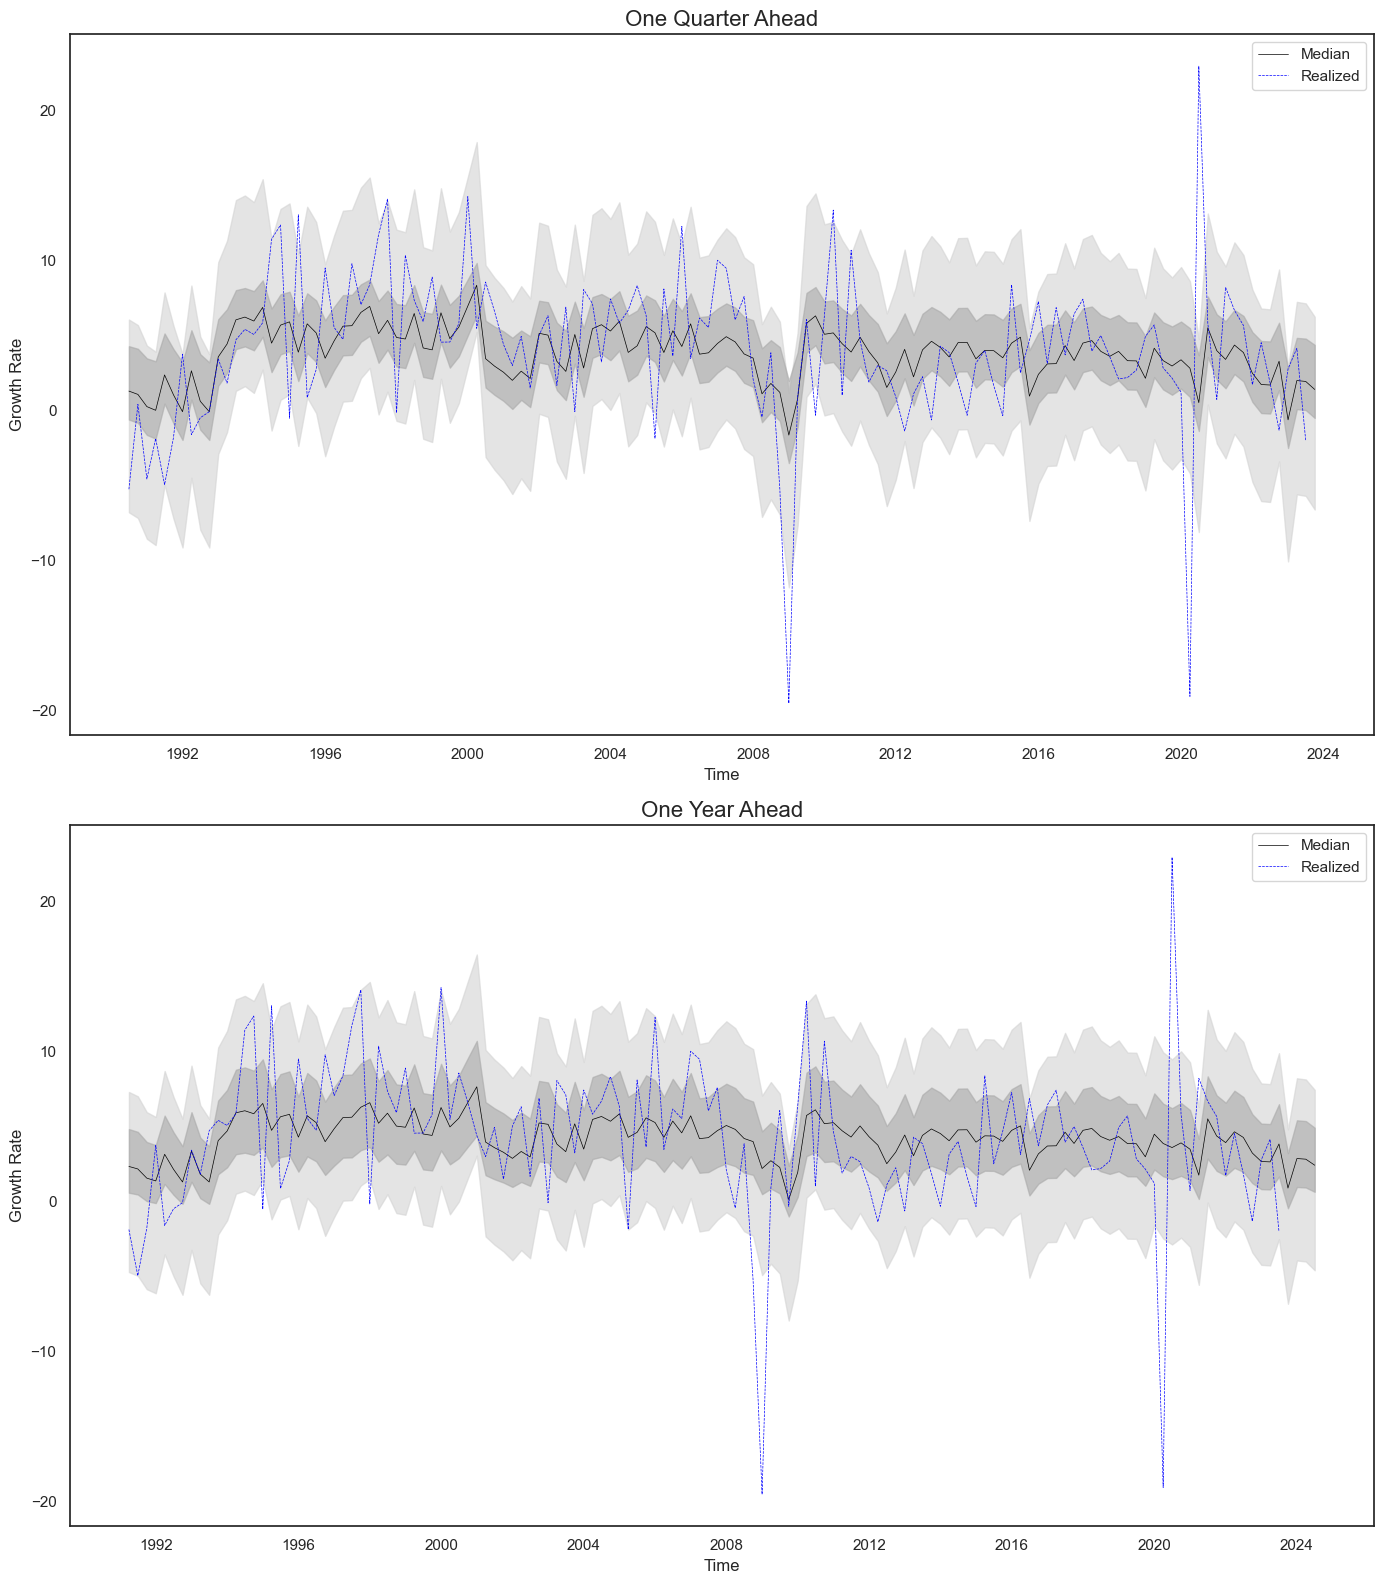

In [48]:
import matplotlib.pyplot as plt

# Assuming q_predict_1_quart and q_predict_4_quart are already defined DataFrames

fig, axs = plt.subplots(2, 1, figsize=(14, 16))

# 1 quarter ahead
t = q_predict_1_quart.index
axs[0].plot(t, q_predict_1_quart[0.5], color="black", linestyle='-', label="Median", linewidth=0.5)
axs[0].plot(t, q_predict_1_quart['realized_ggdp_growth'], color="blue", linestyle='--', label="Realized", linewidth=0.5)
axs[0].fill_between(t, q_predict_1_quart[0.05], q_predict_1_quart[0.95], color="lightgrey", alpha=0.6)
axs[0].fill_between(t, q_predict_1_quart[0.25], q_predict_1_quart[0.75], color="darkgrey", alpha=0.6)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Growth Rate')
axs[0].set_title('One Quarter Ahead', fontsize=16)
axs[0].legend()

# 1 year ahead
t = q_predict_4_quart.index
axs[1].plot(t, q_predict_4_quart[0.5], color="black", linestyle='-', label="Median", linewidth=0.5)
axs[1].plot(t, q_predict_4_quart['realized_ggdp_growth'], color="blue", linestyle='--', label="Realized", linewidth=0.5)
axs[1].fill_between(t, q_predict_4_quart[0.05], q_predict_4_quart[0.95], color="lightgrey", alpha=0.6)
axs[1].fill_between(t, q_predict_4_quart[0.25], q_predict_4_quart[0.75], color="darkgrey", alpha=0.6)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Growth Rate')
axs[1].set_title('One Year Ahead', fontsize=16)
axs[1].legend()

plt.tight_layout()
plt.savefig('plots/predicted_distribution_time_series.png')
plt.show()

## Fitting a skew t distribution

I used R code to fit the t distributions using an optimizer

## Plotting notable financial crises, 1 and 4 quarters ahead 

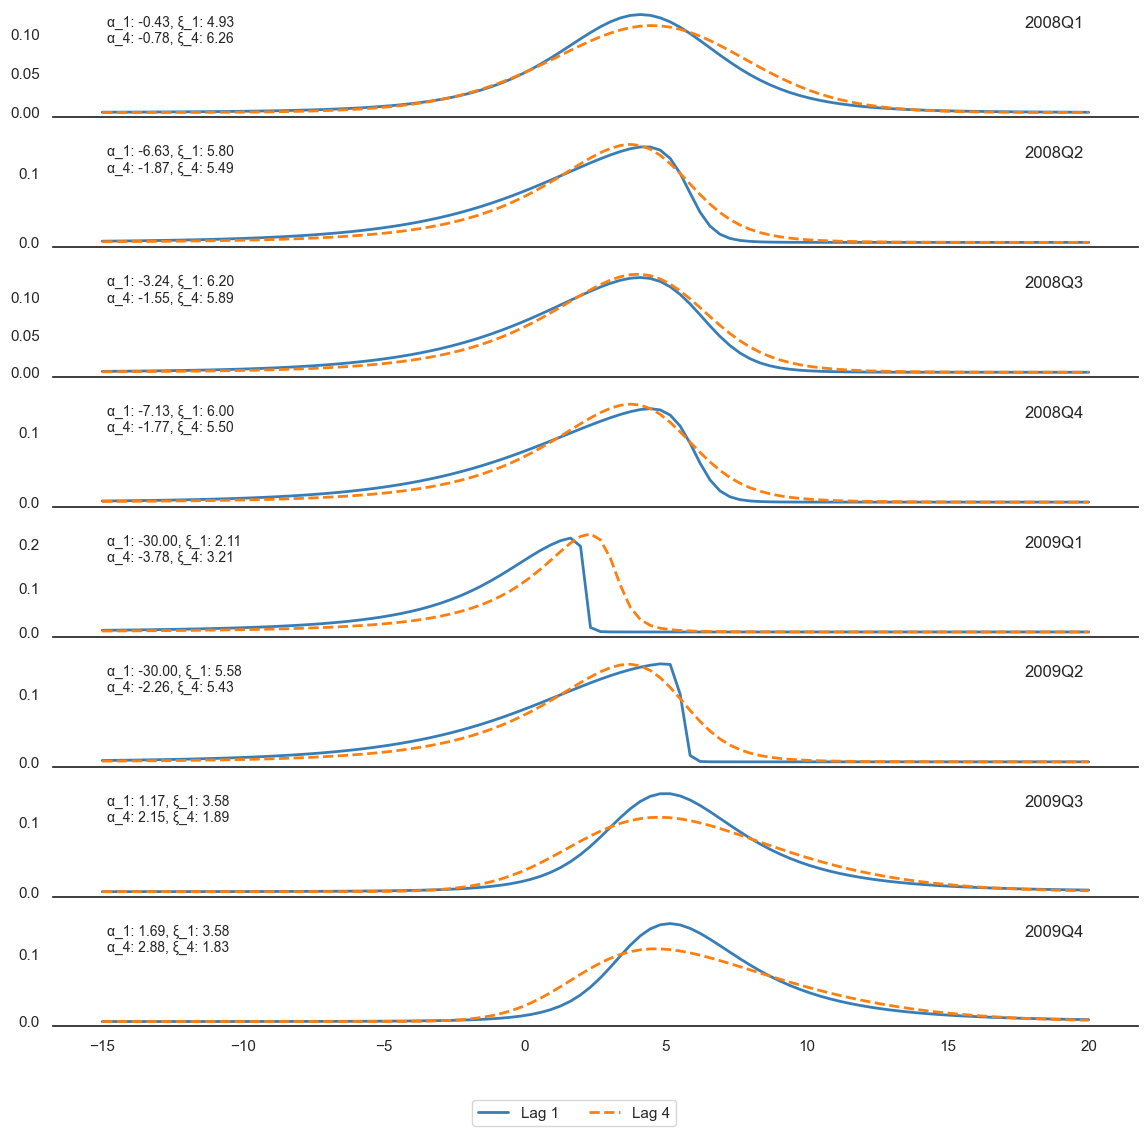

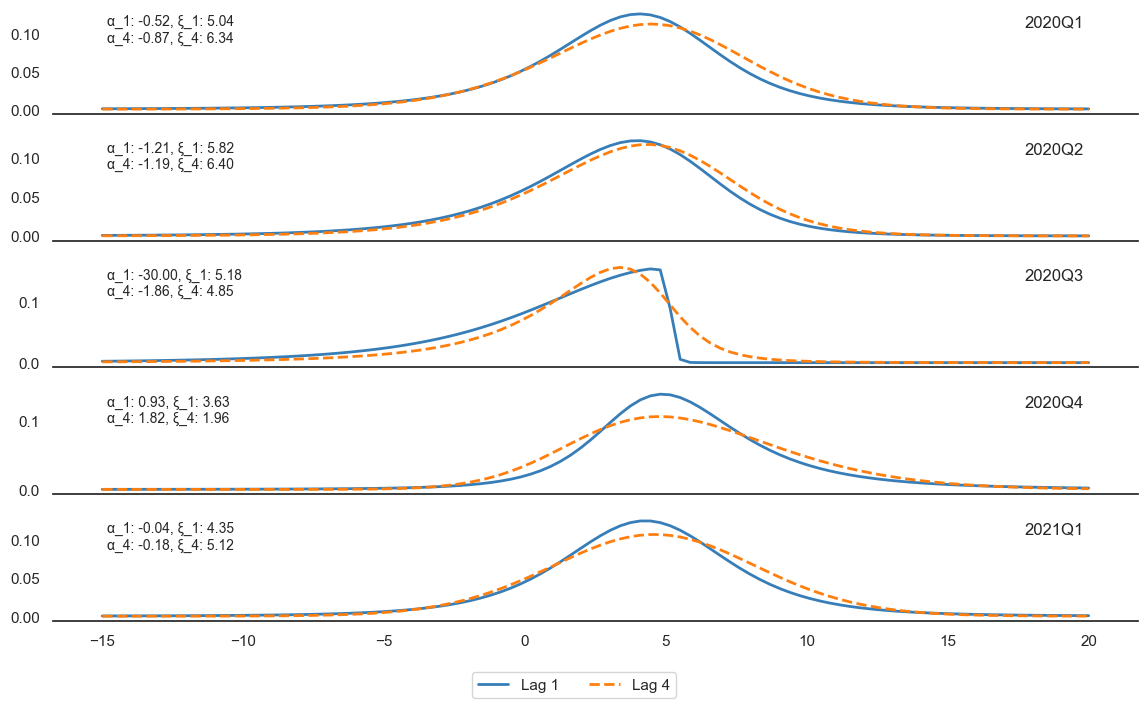

In [49]:
from skewt_scipy.skewt import skewt
import seaborn as sns

sns.set_style("white")

#Loading skewed t distribution estimates

# quantiles_to_plot = np.arange(0.05, 0.96, 0.01, dtype=float)

skew_t_dist_1_quarter = pd.read_csv('gar_analysis/skew_t_dist_1_quarter.csv')
skew_t_dist_1_quarter = skew_t_dist_1_quarter.drop(columns=['Unnamed: 0'])
skew_t_dist_1_quarter.index = pd.to_datetime(skew_t_dist_1_quarter['DATE'])

skew_t_dist_4_quarter = pd.read_csv('gar_analysis/skew_t_dist_4_quarter.csv')
skew_t_dist_4_quarter = skew_t_dist_4_quarter.drop(columns=['Unnamed: 0'])
skew_t_dist_4_quarter.index = pd.to_datetime(skew_t_dist_4_quarter['DATE'])

joint_df = skew_t_dist_4_quarter.join(skew_t_dist_1_quarter, how='left', rsuffix='_1', lsuffix='_4')


def indextime_to_year_quarter(index: pd.Timestamp):
    return f"{index.year}Q{index.quarter}"


def ridge_plot_by_date(begin: str, end: str, joint_df: pd.DataFrame, path: str = None):
    x = np.linspace(-15, 20, 100)
    joint_filtered = joint_df[begin:end]
    num_plots = len(joint_filtered)
    fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(12, num_plots * 1.5), sharex=True)

    # Plotting the distributions
    for i, (index, row) in enumerate(joint_filtered.iterrows()):
        a_1, df_1, loc_1, scale_1 = row[['shape_1', 'freedom_1', 'location_1', 'scale_1']].to_numpy()
        dist_1 = skewt.pdf(x=x, a=a_1, df=df_1, loc=loc_1, scale=scale_1)

        a_4, df_4, loc_4, scale_4 = row[['shape_4', 'freedom_4', 'location_4', 'scale_4']].to_numpy()
        dist_4 = skewt.pdf(x=x, a=a_4, df=df_4, loc=loc_4, scale=scale_4)

        label = indextime_to_year_quarter(index)

        ax = axes[i]
        ax.plot(x, dist_1, label="Lag 1", color='#377eb8', linewidth=2)
        ax.plot(x, dist_4, label="Lag 4", color='#ff7f0e', linestyle='dashed', linewidth=2)
        ax.text(0.95, 0.95, label, transform=ax.transAxes, fontsize=12, va='top', ha='right')
        ax.text(0.05, 0.95, f"α_1: {a_1:.2f}, ξ_1: {loc_1:.2f}\nα_4: {a_4:.2f}, ξ_4: {loc_4:.2f}",
                transform=ax.transAxes, fontsize=10, va='top', ha='left')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)

    # Add legend outside the plot
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2)

    # Adjust layout
    plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])
    if path:
        plt.savefig(path)
    plt.show()


#2008 GFC
ridge_plot_by_date('2008-01-01', '2009-10-01', joint_df, path='plots/ridge_plot_2008_gfc.png')

#2020 COVID
ridge_plot_by_date('2020-01-01', '2021-01-01', joint_df, path='plots/ridge_plot_2020_covid.png')


#Russia-Ukraine War
# Started in Feb 2022
# ridge_plot_by_date('2022-01-01', '2024-01-01', joint_df, path='plots/ridge_plot_2022_russia_ukraine.png')


## Heavy tail analysis

Analysing heavy tails around financial events

We want to analyze the tail index based on the hill estimate


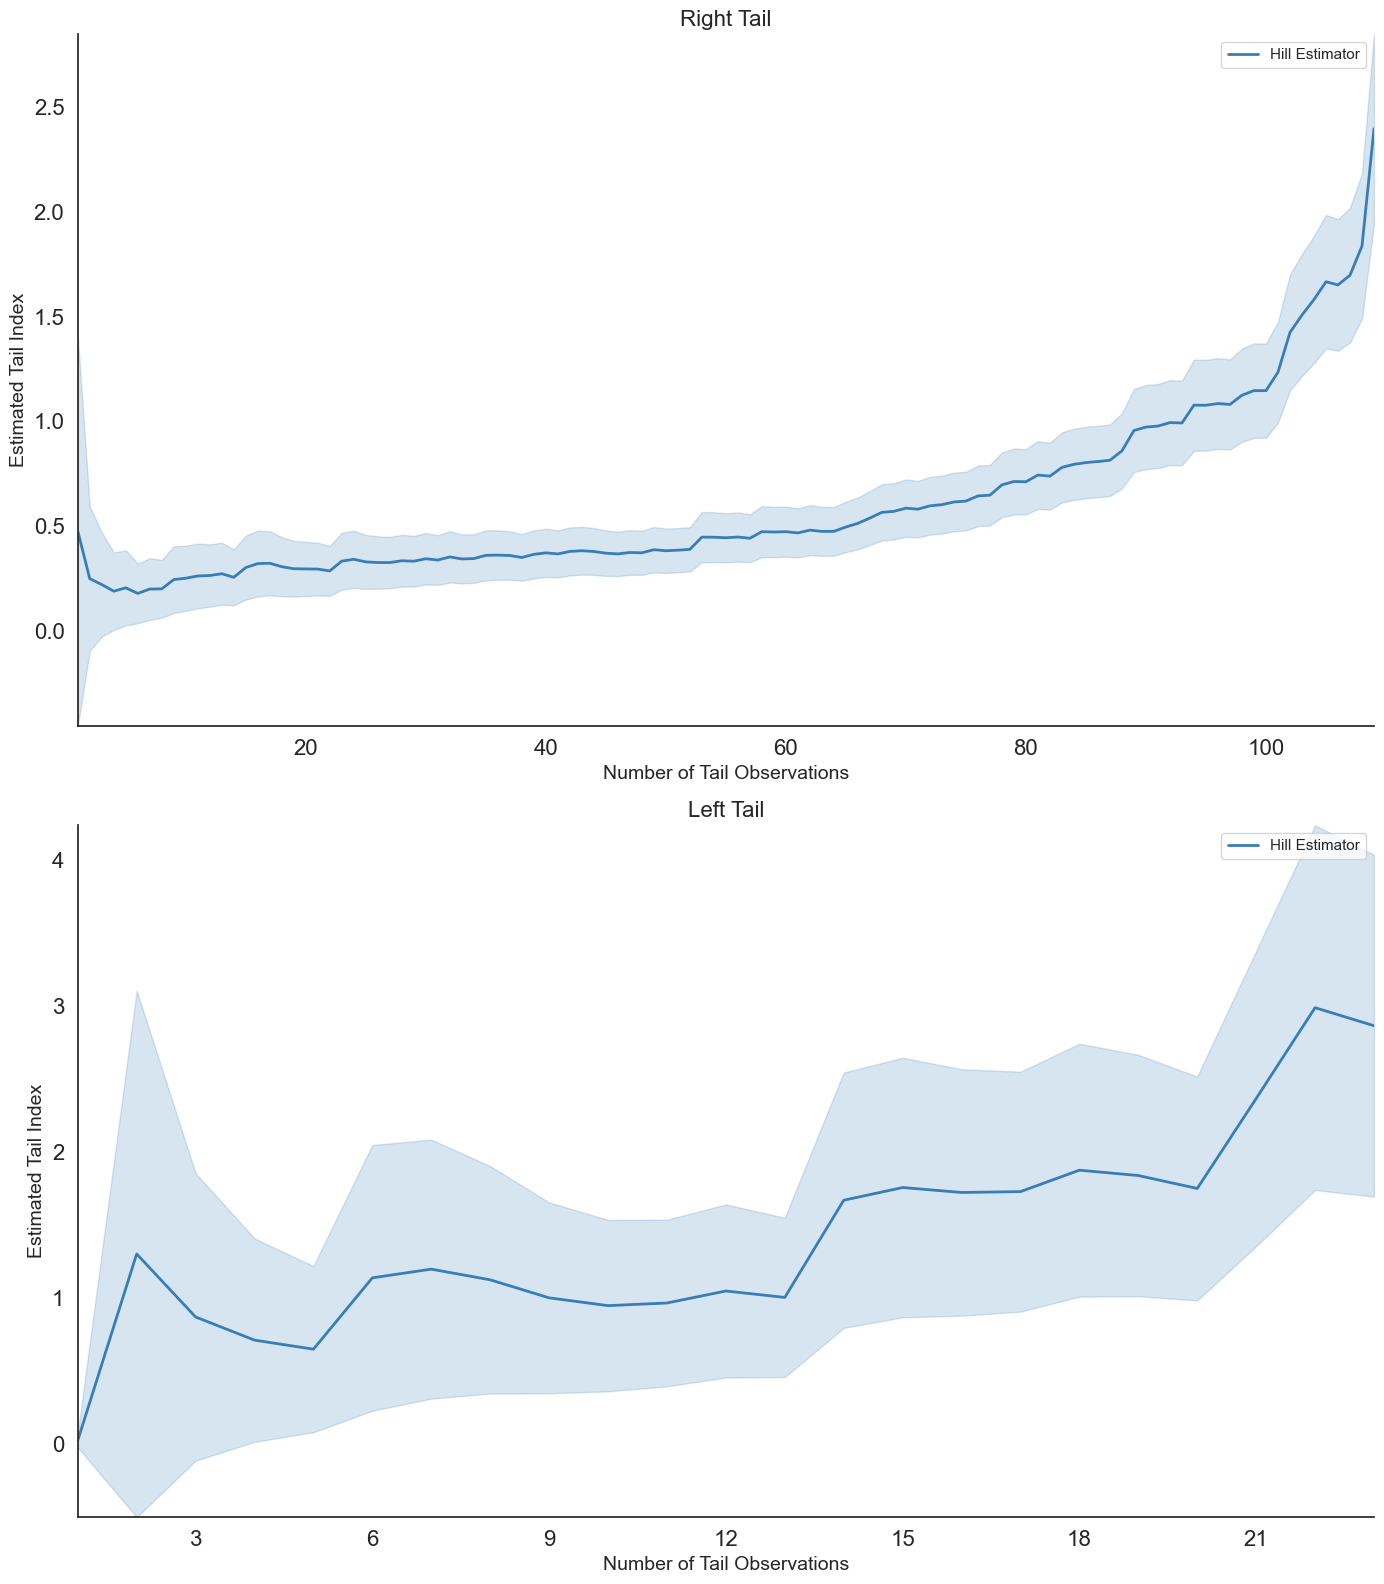

In [76]:
import matplotlib.pyplot as plt
from heavy_tails_functions import HillEstimator
from matplotlib.ticker import MaxNLocator

# Data that I'm using
# fci_quart_data

# shifting data
# we're looking at negative growth
# we want to estimate the left tail index

ggdp_growth_series = fci_quart_data['quarterly_ggdp_ppp_growth_annualized']
ggdp_growth_series = ggdp_growth_series.rename('ggdp_growth')

fig, axs = plt.subplots(2, 1, figsize=(14, 16))

# Right tail index
right_threshold = 0
right_hills_estimator = HillEstimator(ggdp_growth_series, tail='right')
estimator_df_right = right_hills_estimator.estimate_hill_statistic(threshold=right_threshold)

axs[0].plot(estimator_df_right['num_tail_observations'], estimator_df_right['estimate'], label='Hill Estimator', color='#377eb8', linestyle='-', linewidth=2)
axs[0].fill_between(estimator_df_right['num_tail_observations'], estimator_df_right['ci_lower'], estimator_df_right['ci_upper'], color="#377eb8", alpha=0.2)

axs[0].set_xlim(estimator_df_right['num_tail_observations'].min(), estimator_df_right['num_tail_observations'].max())
axs[0].set_ylim(estimator_df_right['ci_lower'].min(), estimator_df_right['ci_upper'].max())
axs[0].set_title('Right Tail', fontsize=16)
axs[0].set_xlabel('Number of Tail Observations', fontsize=14)
axs[0].set_ylabel('Estimated Tail Index', fontsize=14)
axs[0].legend(loc='best')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].tick_params(axis='both', which='major', labelsize=16)

# Left tail index
left_threshold = 0
left_hills_estimator = HillEstimator(ggdp_growth_series, tail='left')
estimator_df_left = left_hills_estimator.estimate_hill_statistic(threshold=left_threshold)

axs[1].plot(estimator_df_left['num_tail_observations'], estimator_df_left['estimate'], label='Hill Estimator', color="#377eb8", linestyle='-', linewidth=2)
axs[1].fill_between(estimator_df_left['num_tail_observations'], estimator_df_left['ci_lower'], estimator_df_left['ci_upper'], color="#377eb8", alpha=0.2)

axs[1].set_xlim(estimator_df_left['num_tail_observations'].min(), estimator_df_left['num_tail_observations'].max())
axs[1].set_ylim(estimator_df_left['ci_lower'].min(), estimator_df_left['ci_upper'].max())
axs[1].set_title('Left Tail', fontsize=16)
axs[1].set_xlabel('Number of Tail Observations', fontsize=14)
axs[1].set_ylabel('Estimated Tail Index', fontsize=14)
axs[1].legend(loc='best')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig('plots/hills_estimator.png')
plt.show()


In [9]:
#comment to push